# Telecom Churn Project 

## Final Model Fit and Graphing

The model parameters used in this notebook were generated in the Model Search notebook

In [2]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import umap


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Read the training data file.  This file was created by running the notebooks:
* Telecom to SQL
* Telecom clean and eda

In [7]:
def calc_roc_data(model, X_dat, y_dat, n_step) :
    threshold_list = np.linspace(0, 1, n_step, endpoint=True)
    roc_data = [[0,0,0]]

    for i, threshold in enumerate(threshold_list) :
        y_predict = (model.predict_proba(X_dat)[:, 1] >= threshold)
        confusion_m = confusion_matrix(y_dat, y_predict)
        fpr = confusion_m[1][0] / (confusion_m[1][0]+confusion_m[1][1])
        tpr = confusion_m[0][0] / (confusion_m[0][0]+confusion_m[0][1])
        roc_data.append([threshold, fpr, tpr])
        
    roc_data.append([1,1,1])    

    return roc_data

######

def cal_f_beta(tpr, fpr, beta) :
    weighted_ave = (beta**2 * (tpr+1) * fpr) / (beta**2 + 1)
    return (tpr*fpr) / weighted_ave

In [8]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv').drop('Unnamed: 0', axis=1)

train_df.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'Month-to-month', 'One year', 'DSL', 'Fiber optic', 'Female'],
      dtype='object')

In [9]:
# Define which columns we're going to use in our modeling.
train_columns1 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Month-to-month', 'One year', 'Fiber optic', 'Female']

train_columns2 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', \
       'Month-to-month', 'One year', 'Fiber optic', 'MonthlyCharges', 'Female']

train_columns = train_columns2

X = train_df[train_columns]
y= train_df['Churn']

In [10]:
# Split the original dataset into train and validation groups
#  set stratify to true so both classes are represented it the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Make a balance set for model training
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

### Best model for Logistic Regression

In [11]:
log_best = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=45)
log_best.fit(X_train_smt,y_train_smt)
y_hat = log_best.predict(X_test)
print(accuracy_score(y_test, y_hat))

0.7682119205298014


In [12]:
roc_data_log = calc_roc_data(log_best, X_test, y_test, 20)

In [13]:
x_plt_log = [roc_data_log[i][1] for i in range(len(roc_data_log))]
y_plt_log = [roc_data_log[i][2] for i in range(len(roc_data_log))]


Text(0.5, 1.0, 'ROC\n')

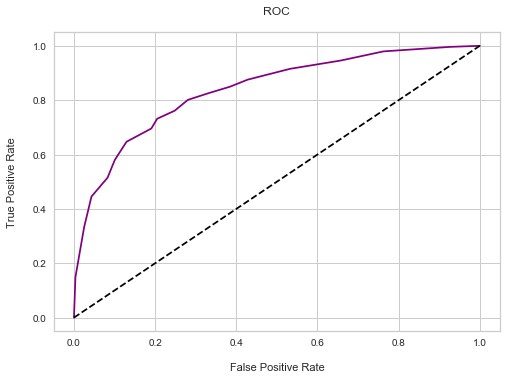

In [15]:
plt.plot(x_plt_log, y_plt_log, color='purple')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate')
plt.ylabel('True Positive Rate\n')
plt.title('ROC\n')

### Best model for KNN

In [16]:
knn_best = KNeighborsClassifier(n_neighbors=4)
knn_best.fit(X_train_smt, y_train_smt)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [17]:
roc_data_knn = calc_roc_data(knn_best, X_test, y_test, 20)
x_plt_knn = [roc_data_knn[i][1] for i in range(len(roc_data_knn))]
y_plt_knn = [roc_data_knn[i][2] for i in range(len(roc_data_knn))]

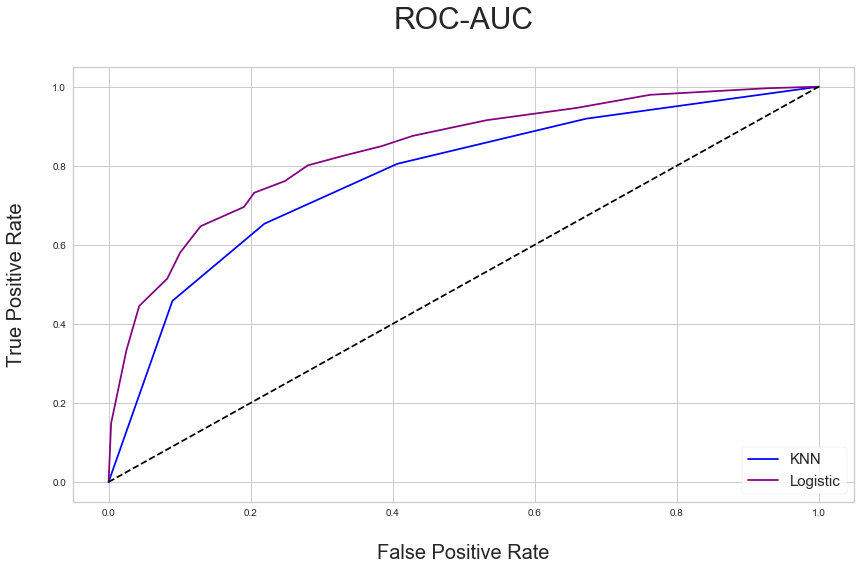

In [18]:
fig = plt.figure(figsize = [14,8])
knn_line = plt.plot(x_plt_knn, y_plt_knn, color='blue', label='KNN')
log_line = plt.plot(x_plt_log, y_plt_log, color='purple', label='Logistic')

fig.patch.set_alpha(0.)

plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate', size=20)
plt.ylabel('True Positive Rate\n', size=20)
plt.title('ROC-AUC\n', size=30)
plt.legend(loc='lower right', fontsize=15, frameon=True)
plt.show()

# Best model for Random Forest Classifier

In [19]:
rf_best = RandomForestClassifier(max_depth=4, max_features=5, n_estimators=50, criterion='gini', random_state=42)

In [20]:
rf_best.fit(X_train_smt, y_train_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
roc_data_rf = calc_roc_data(rf_best, X_test, y_test, 40)
x_plt_rf = [roc_data_rf[i][1] for i in range(len(roc_data_rf))]
y_plt_rf = [roc_data_rf[i][2] for i in range(len(roc_data_rf))]

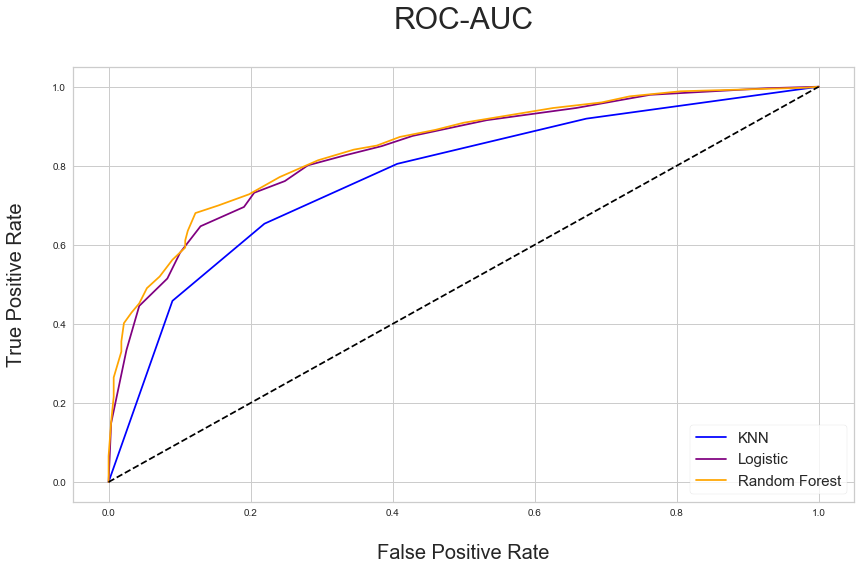

In [22]:
fig = plt.figure(figsize = [14,8])
knn_line = plt.plot(x_plt_knn, y_plt_knn, color='blue', label='KNN')
log_line = plt.plot(x_plt_log, y_plt_log, color='purple', label='Logistic')
rf_line = plt.plot(x_plt_rf, y_plt_rf, color='orange', label='Random Forest')

fig.patch.set_alpha(0.)

plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate', size=20)
plt.ylabel('True Positive Rate\n', size=20)
plt.title('ROC-AUC\n', size=30)
plt.legend(loc='lower right', fontsize=15, frameon=True)
plt.show()

Check the feature importance

In [23]:
rf_importances = rf_best.feature_importances_
rf_importances

array([0.00060699, 0.02400224, 0.03713433, 0.15481988, 0.00612632,
       0.00160939, 0.08633128, 0.01089164, 0.01078514, 0.06982469,
       0.00365889, 0.00289569, 0.33590557, 0.0115285 , 0.10748534,
       0.13388435, 0.00250977])

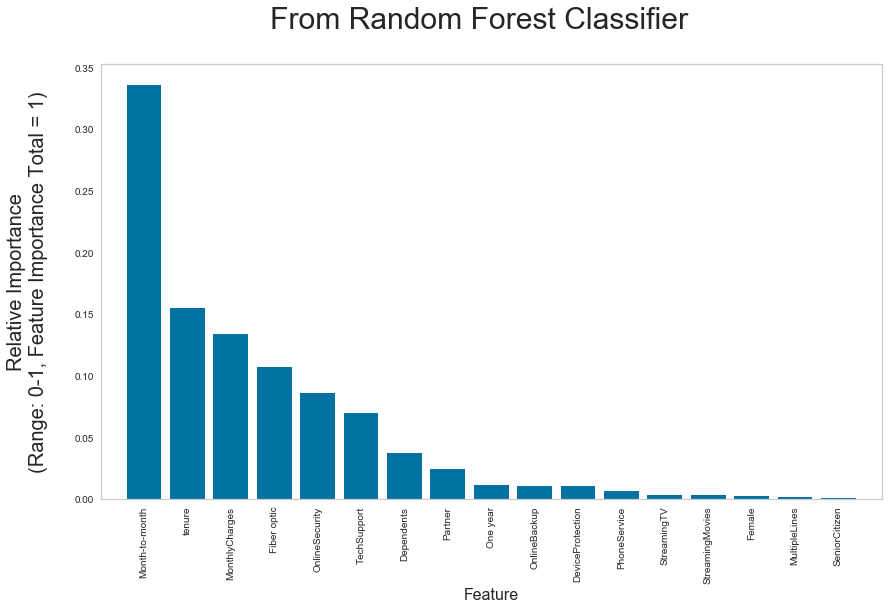

<Figure size 576x396 with 0 Axes>

In [24]:
# Plot the feature importances of the forest
indices = np.argsort(rf_importances)[::-1]
index_labels = [X_train.columns[x] for x in indices]

fig = plt.figure(figsize=[14,8])

fig.patch.set_alpha(0.)

plt.grid(0)
plt.suptitle("Feature importances", size=30)
plt.suptitle("From Random Forest Classifier\n", size=30)
plt.xlabel('Feature', size=16)
plt.ylabel('Relative Importance\n(Range: 0-1, Feature Importance Total = 1)\n', size=20)
plt.bar(range(X_train.shape[1]), rf_importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), labels=index_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
plt.savefig('FeatureImportances.png', Transparent=True)

## Best model for Support Vector Classifier

In [25]:
svc_best = SVC(C=1.5, kernel='linear', random_state = 42, probability=True)

In [26]:
svc_best.fit(X_train_smt, y_train_smt)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [27]:
roc_data_svc = calc_roc_data(svc_best, X_test, y_test, 40)
x_plt_svc = [roc_data_svc[i][1] for i in range(len(roc_data_svc))]
y_plt_svc = [roc_data_svc[i][2] for i in range(len(roc_data_svc))]

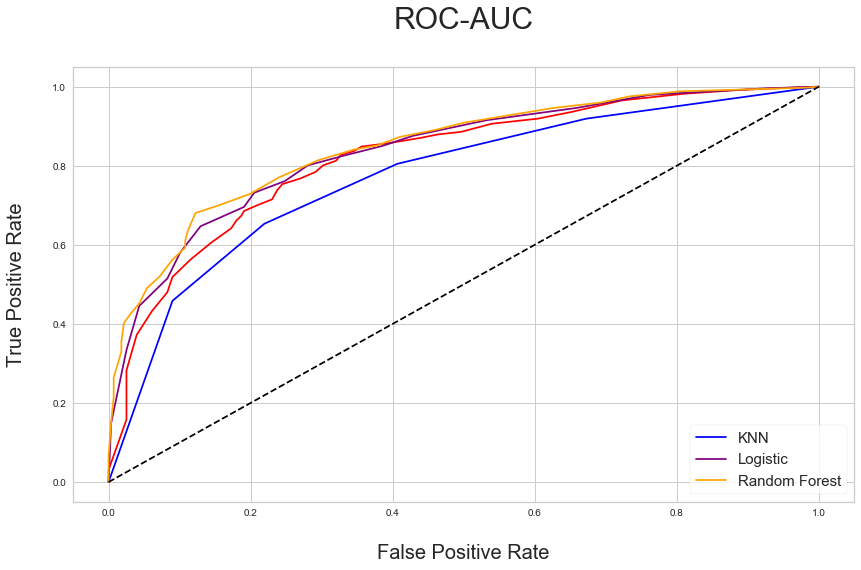

<Figure size 576x396 with 0 Axes>

In [28]:
fig = plt.figure(figsize = [14,8])

fig.patch.set_alpha(0.)

svc_line = plt.plot(x_plt_svc, y_plt_svc, color='red')

knn_line = plt.plot(x_plt_knn, y_plt_knn, color='blue', label='KNN')
log_line = plt.plot(x_plt_log, y_plt_log, color='purple', label='Logistic')
rf_line = plt.plot(x_plt_rf, y_plt_rf, color='orange', label='Random Forest')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate', size=20)
plt.ylabel('True Positive Rate\n', size=20)
plt.title('ROC-AUC\n', size=30)
plt.legend(loc='lower right', fontsize=15, frameon=True)
plt.show()
plt.savefig('ROC_all.png')

## Best model for Naive Bayes

In [31]:
nb_best = GaussianNB()

In [32]:
nb_best.fit(X_train_smt, y_train_smt)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
roc_data_nb = calc_roc_data(nb_best, X_test, y_test, 40)
x_plt_nb = [roc_data_nb[i][1] for i in range(len(roc_data_nb))]
y_plt_nb = [roc_data_nb[i][2] for i in range(len(roc_data_nb))]

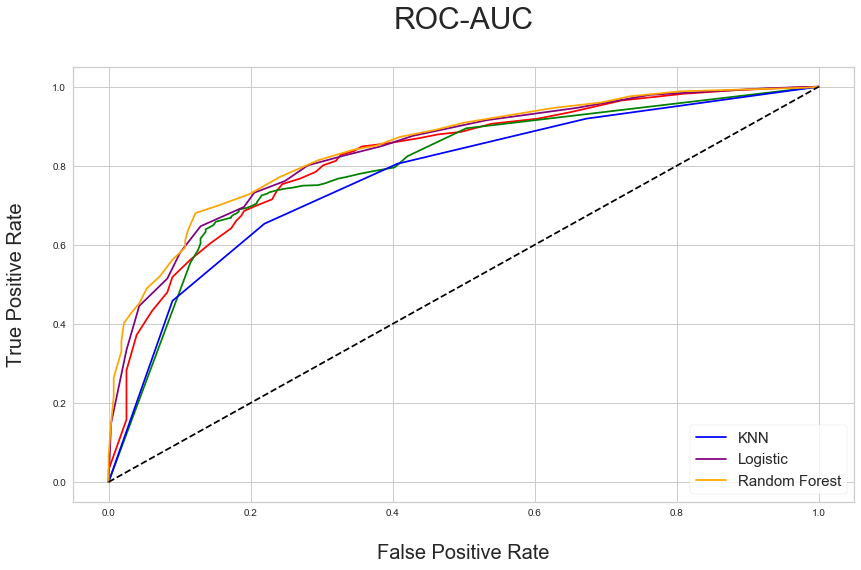

<Figure size 576x396 with 0 Axes>

In [34]:
fig = plt.figure(figsize = [14,8])

fig.patch.set_alpha(0.)

svc_line = plt.plot(x_plt_svc, y_plt_svc, color='red')
nb_line = plt.plot(x_plt_nb, y_plt_nb, color='green')
knn_line = plt.plot(x_plt_knn, y_plt_knn, color='blue', label='KNN')
log_line = plt.plot(x_plt_log, y_plt_log, color='purple', label='Logistic')
rf_line = plt.plot(x_plt_rf, y_plt_rf, color='orange', label='Random Forest')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate', size=20)
plt.ylabel('True Positive Rate\n', size=20)
plt.title('ROC-AUC\n', size=30)
plt.legend(loc='lower right', fontsize=15, frameon=True)
plt.show()
plt.savefig('ROC_all.png')